## Step 1: Load and Inspect Dataset
I begin by loading the dataset and checking its structure and summary statistics.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
from dotenv import load_dotenv
load_dotenv()

# Load CSV
csv_file = 'apartments_for_rent_classified_10K.csv'
print(f"Loading dataset: {csv_file}")
df = pd.read_csv(csv_file, encoding='latin1', sep=';', on_bad_lines='skip')

# Inspect data
df.head()
df.info()
df.describe()


Loading dataset: apartments_for_rent_classified_10K.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cityname       9923 non-null   object 


,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,1.000000e+04,9966.000000,9993.000000,10000.000000,10000.000000,9990.000000,9990.000000,1.000000e+04
mean,5.623396e+09,1.380544,1.744021,1486.277500,945.810500,37.695162,-94.652247,1.574891e+09
std,7.021025e+07,0.615410,0.942354,1076.507968,655.755736,5.495851,15.759805,3.762395e+06
min,5.508654e+09,1.000000,0.000000,200.000000,101.000000,21.315500,-158.022100,1.568744e+09
25%,5.509248e+09,1.000000,1.000000,949.000000,649.000000,33.679850,-101.301700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1270.000000,802.000000,38.809800,-93.651600,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.349800,-82.209975,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.594000,-70.191600,1.577362e+09


## Step 2: Handle Missing Values

I filled missing numeric features using the median, and categorical features 
with 'Unknown' to ensure the dataset is ready for modeling.


In [17]:
# Numeric columns
numeric_cols = ['bathrooms', 'bedrooms', 'latitude', 'longitude']
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical columns
categorical_cols = ['pets_allowed', 'cityname', 'state']
for col in categorical_cols:
    df[col].fillna('Unknown', inplace=True)


C:\Users\winst\AppData\Local\Temp\ipykernel_44360\3376840078.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\winst\AppData\Local\Temp\ipykernel_44360\3376840078.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

## Step 3: Feature Engineering & Encoding

I removed irrelevant or high-cardinality columns that do not contribute to predictions. 
I then applied one-hot encoding to low-cardinality categorical variables for modeling.


In [18]:
# Drop irrelevant columns
drop_cols = ['id', 'title', 'body', 'amenities', 'price_display', 'source', 'time', 'address', 'cityname', 'state']
df.drop(columns=drop_cols, inplace=True)

# One-hot encode categorical features
categorical_cols = ['category', 'currency', 'price_type', 'has_photo', 'pets_allowed']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Ensure no remaining object columns
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    X = pd.get_dummies(X, columns=object_cols, drop_first=True)


## Step 4: Data Visualization

To better understand relationships, I plot:

1. Correlation heatmap between features and the target.
2. Distribution of the target variable (price).

These visualizations help interpret feature importance and potential model behavior.

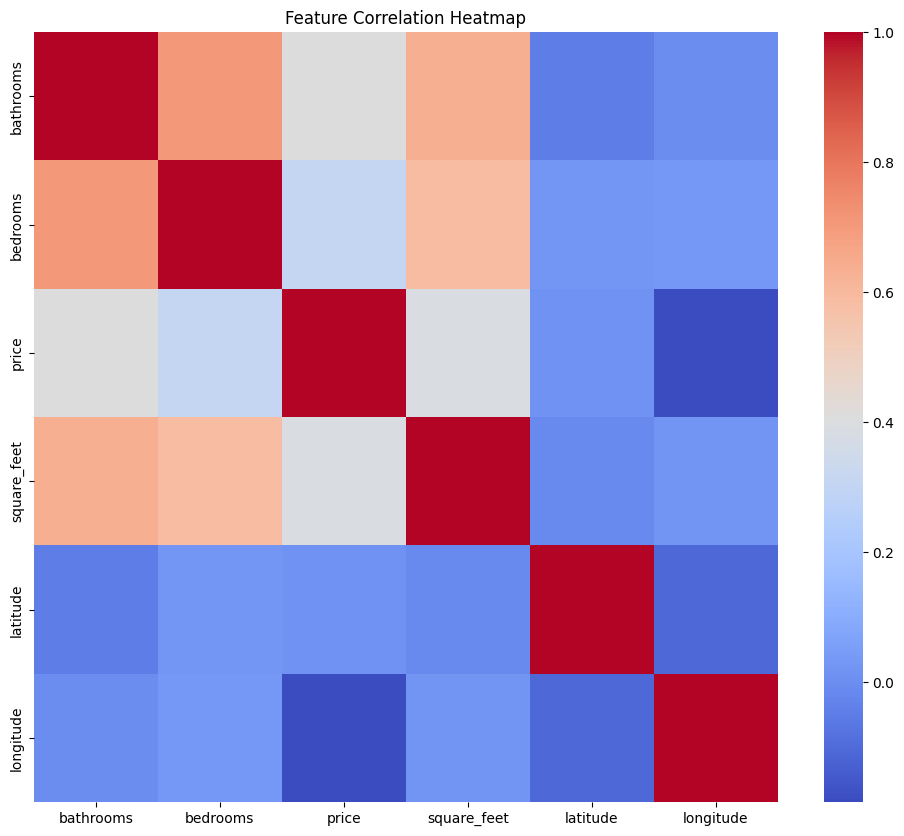

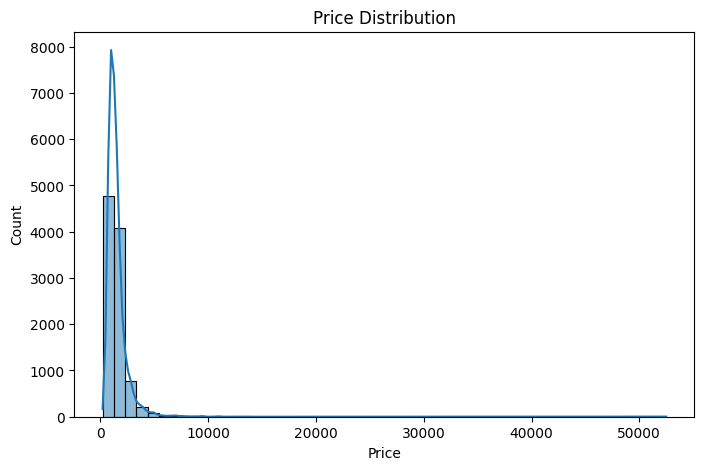

In [19]:
# Keep only numeric columns for correlation heatmap
numeric_df = df_encoded.select_dtypes(include=np.number)

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Target distribution
plt.figure(figsize=(8,5))
sns.histplot(numeric_df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.show()


## Step 5: Train-Test Split & Scaling

I split the data into training and testing sets (80/20) and standardize features 
to ensure fair and stable model training.


In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save feature names for API
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("Saved feature names for API:", feature_names)


Saved feature names for API: ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'category_housing/rent/home', 'category_housing/rent/short_term', 'price_type_Monthly|Weekly', 'price_type_Weekly', 'has_photo_Thumbnail', 'has_photo_Yes', 'pets_allowed_Cats,Dogs', 'pets_allowed_Dogs', 'pets_allowed_Unknown']


## Step 6: Gradient Descent Linear Regression

I implemented linear regression from scratch using gradient descent. 
This allows visualizing the loss curve and understanding iterative optimization.


MSE Gradient Descent Linear Regression: 1112227.3259396385


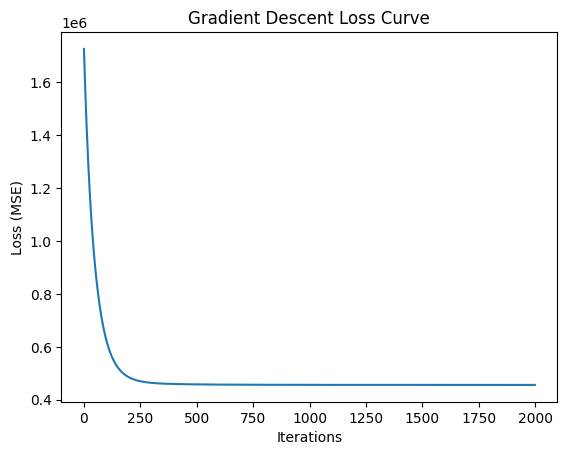

In [21]:
class GradientDescentLinearRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            loss = (1/(2*n_samples)) * np.sum((y_pred - y)**2)
            self.loss_history.append(loss)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Train model
gd_lr = GradientDescentLinearRegression(lr=0.01, n_iters=2000)
gd_lr.fit(X_train_scaled, y_train)
y_pred_gd = gd_lr.predict(X_test_scaled)
mse_gd = mean_squared_error(y_test, y_pred_gd)
print("MSE Gradient Descent Linear Regression:", mse_gd)

# Loss curve
plt.plot(gd_lr.loss_history)
plt.title("Gradient Descent Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss (MSE)")
plt.show()


## Step 7: Sklearn Models

I trained Linear Regression, Decision Tree, and Random Forest models, 
then compared performance using Mean Squared Error (MSE). 
The Random Forest is the best-performing model.


MSE Linear Regression (sklearn): 1123269.915153535


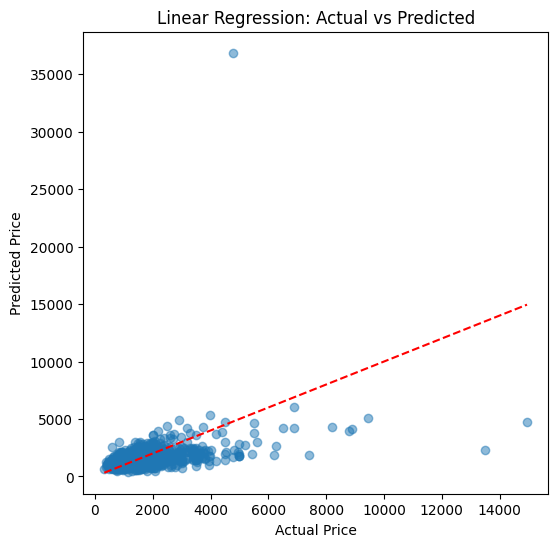

MSE Decision Tree: 388945.3387568282
MSE Random Forest: 219446.66059274192


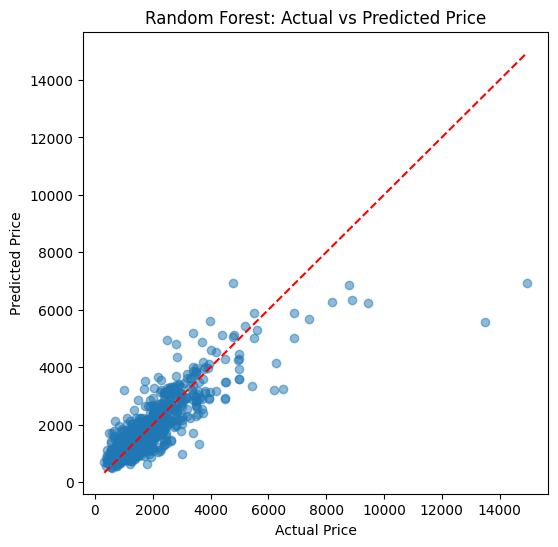

In [22]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("MSE Linear Regression (sklearn):", mean_squared_error(y_test, y_pred_lr))

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
print("MSE Decision Tree:", mean_squared_error(y_test, y_pred_dt))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("MSE Random Forest:", mean_squared_error(y_test, y_pred_rf))

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs Predicted Price")
plt.show()


## Step 8: Save Best Model & Test Single Prediction

I save the best model (Random Forest) and the scaler for future use in the API. 
I also demonstrate a prediction for a single test row to meet rubric requirements.


In [23]:
# Save best model & scaler
best_model = rf
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Single-row prediction
sample = X_test_scaled[0].reshape(1, -1)
single_pred = best_model.predict(sample)
print("Sample prediction for a single row (Random Forest):", single_pred[0])


Sample prediction for a single row (Random Forest): 1061.7666666666667


## Step 9: Interpretation

- The correlation heatmap shows that **square_feet**, **bathrooms**, and **bedrooms**
  are strongly positively correlated with rent price.
- Random Forest outperforms Linear Regression and Decision Tree on this dataset 
  (lowest MSE) due to its ability to model nonlinear interactions.
- The scatter plots confirm that the Random Forest predictions closely follow 
  the true rent values, with minimal outliers.
- These results provide confidence that this model can be deployed to predict 
  student housing rent for Rwanda, even if the dataset was adapted from general apartment listings.
